## ***Hiyerarsik Kumeleme Algoritmasi***

Bu ödevde, UC Irvine Machine Learning Repository'de bulunan [kalp hastalığı veri seti](http://archive.ics.uci.edu/ml/datasets/Heart+Disease)yle çalışacaksınız.
- Üç farklı linkage yöntemini kullanarak kalp hastalığı veri kümesi için dendrogramlar üretin: “mean”, “complete” ve “ward”. Sizce hangi bağlantı yöntemi daha iyi sonuç vermektedir?

- n_clusters = 2 ayarını yaparak kalp hastalığı verilerine yığınsal kümeleme uygulayın. Yukarıdaki üç bağlantı yöntemini deneyin ve her bir çözümünüz için ARI ve siluet skorları elde edin. Sonuçları birbirleriyle ve önceki bölümde uyguladığınız k-ortalama çözümü ile karşılaştırın. Hangi algoritma ve ayar daha iyi performans gösterir?

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

- Veri seti kümeleme algoritmasına geçmeden önce bazı işlemlere ihtiyaç duymaktadır.

#### Preprocessing

In [32]:
# birden fazla dosyayi okuma
import glob

path = r'./data' # use your path
all_files = glob.glob(path + "/processed*.data")

li = []

for filename in all_files:
    df = pd.read_csv(filename,header=0)
    # sutun isimlerini ayni yapiyoruz ki concat etmede sutun sayimiz artmasin
    # farkli isimdeki sutunlar olusmasin
    df.columns = [x for x in range(14)]
    li.append(df)

heart = pd.concat(li, axis=0, ignore_index=True)

In [33]:
heart

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,34.0,1.0,4.0,115,0,?,?,154,0,.2,1,?,?,1
1,35.0,1.0,4.0,?,0,?,0,130,1,?,?,?,7,3
2,36.0,1.0,4.0,110,0,?,0,125,1,1,2,?,6,1
3,38.0,0.0,4.0,105,0,?,0,166,0,2.8,1,?,?,2
4,38.0,0.0,4.0,110,0,0,0,156,0,0,2,?,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,45.0,1.0,1.0,110,264,0,0,132,0,1.2,2,0.0,7.0,1
912,68.0,1.0,4.0,144,193,1,0,141,0,3.4,2,2.0,7.0,2
913,57.0,1.0,4.0,130,131,0,0,115,1,1.2,2,1.0,7.0,3
914,57.0,0.0,2.0,130,236,0,2,174,0,0,2,1.0,3.0,1


- Burada, X sizin özellikleriniz olacak ve y içinde etiketleri tutuyoruz. Y, 1'e eşitse, o zaman buna karşılık gelen hastanın kalp hastalığı olduğunu ve y'nin 0'a eşit olması durumunda, hastanın kalp hastalığı olmadığı anlaşılacaktır.

In [34]:
# Veri setini kullanmadan önce bazı ön işlemler yapmanız gerekiyor:

# Define the features and the outcome
X = heart.iloc[:, :13]
y = heart.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

- Kümeleme algoritmalalarının çoğu değişkenlerin ölçeklerine duyarlı olduklarından değişkenleri standartlaştırıyoruz

In [35]:
# kümeleme algoritmalalarının çoğu değişkenlerin ölçeklerine duyarlı olduklarından 
# değişkenleri standartlaştırıyoruz
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

---
#### ***Dendogram***
- Üç farklı linkage yöntemi icin uretildi. (``` ward, complete, mean(average)```)

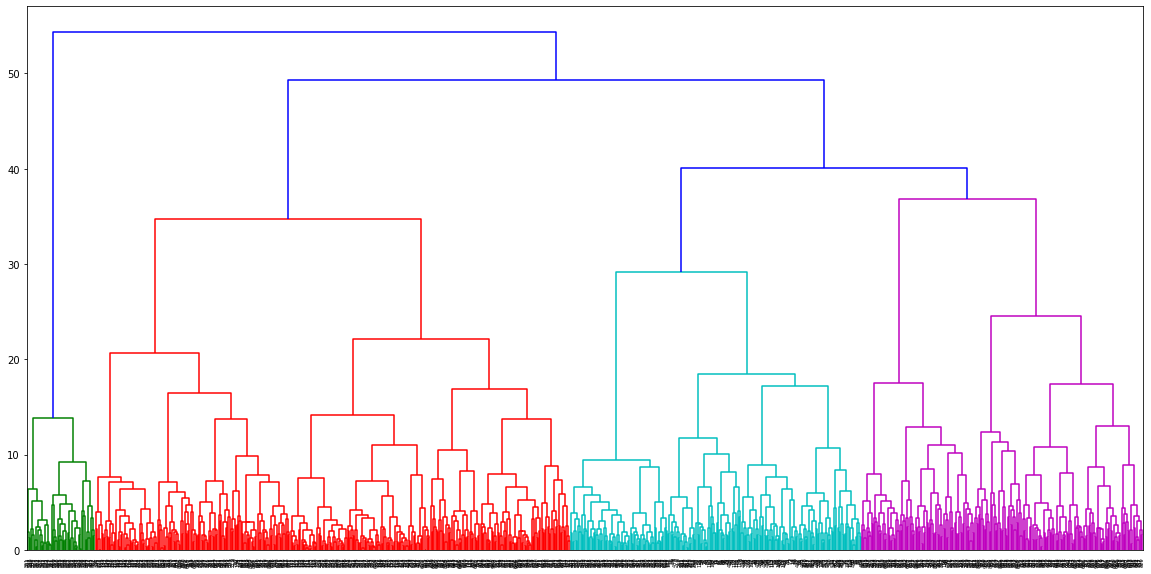

In [9]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.show()

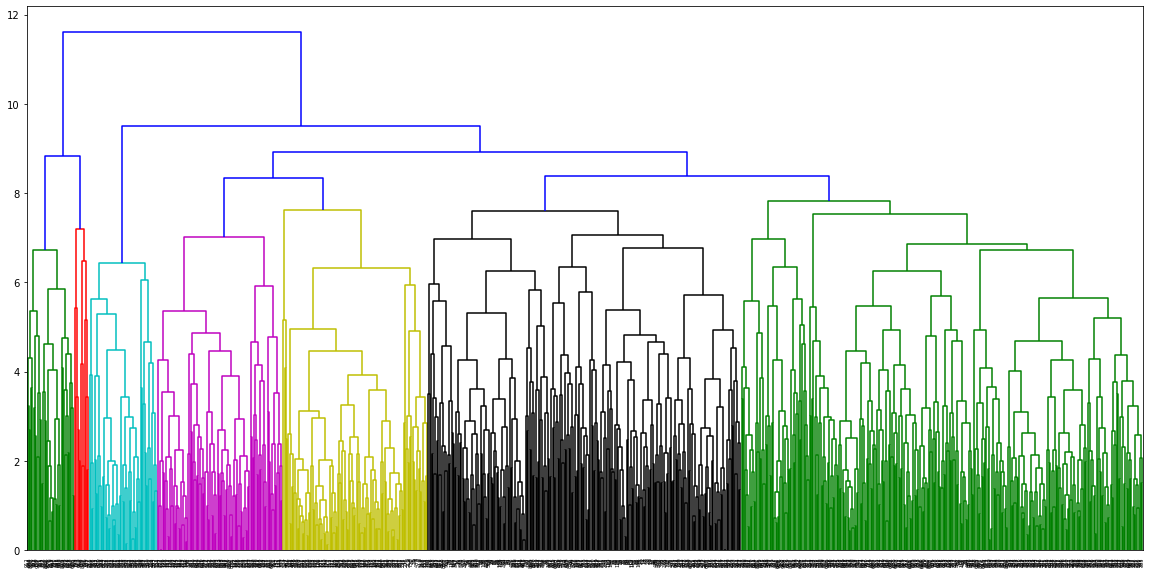

In [5]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

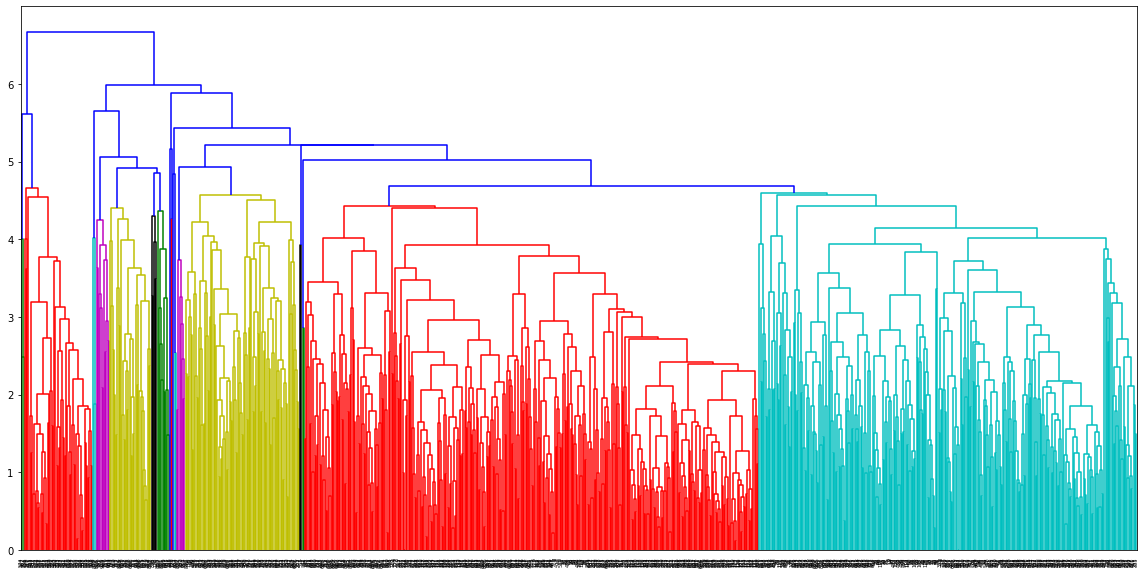

In [37]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='average'))
plt.show()

- Asagidaki ARI skorlarina bakacak olursak en iyi sonucu average en kotu sonucu ward vermektedir. Yukaridaki grafikler incelenirse kume sayisinin 2 kumeye dustugunde y eksenindeki mesafe olcegi ward linkage yonteminde 50 civarindayken, average yonteminde bu mesafe 6 ya kadar dusmustur. Bunun sebebi ward lnkage yonteminin ```cosine``` mesafe yontemini kullanmamasi yalnizaca ```euclidean``` mesafe ile kumeleme yapmasi sebep olmus olabilir.

- Asagida skorlama hesabinda average ve complete icin ```affinity='euclidean'``` secildiginde de Siluet skorlari artmasina ragmen ARI skorlari dusmustur.

---
### ***Yiginsal Kumeleme (Agglomerative Clustering) ARI ve Siluet Skorlari***
- ```n_clusters = 2``` parametresi ve üç bağlantı yöntemi (```complete,ward,mean(average)```) ile kumelemeler olusturulacak ve her bir çözüm için ARI ve siluet skorları elde edilecektir.
- ARI ile, 0'dan küçük değerler elde etmek mümkündür, ancak 1 mükemmel uyumu, 0 ise mükemmel rastgeleliği gösterir.

In [42]:
linkages = ['ward', 'complete', 'average']

for i, linkage in enumerate(linkages):
    # Yığınsal Kümelemenin Tanımlanması
    if linkage=='ward':        
        agg_cluster = AgglomerativeClustering(n_clusters=2, linkage=linkage, affinity='euclidean')
    else:
        agg_cluster = AgglomerativeClustering(n_clusters=2, linkage=linkage, affinity='cosine')

    # Modeli Fit Etmek
    clusters = agg_cluster.fit_predict(X_std)
    
    print('Silhouette Score for {} linkage\t :{:.6f}'.format(linkage, 
                                                           metrics.silhouette_score(X_std, clusters,
                                                                         metric='euclidean')))

    print('ARI Score for {} linkage\t\t :{:.6f}'.format(linkage, 
                                                           metrics.adjusted_rand_score(y, clusters)))
    print('-'*50)

Silhouette Score for ward linkage	 :0.310011
ARI Score for ward linkage		 :-0.003910
--------------------------------------------------
Silhouette Score for complete linkage	 :0.031176
ARI Score for complete linkage		 :0.078612
--------------------------------------------------
Silhouette Score for average linkage	 :0.112250
ARI Score for average linkage		 :0.163399
--------------------------------------------------


- K-ortalama algoritmasi ile skorlar:
    - ARI: 0.23
    - Siluet: 0.15
- Hiyerarsik kumeleme algoritmasi ile skorlar
    - ARI: 0.16 (en yuksek average linkage yontemi ile)
    - Siluet: 0.31 (en yuksek ward linkage yontemi ile)    
- Yukaridaki karsilastirmdan da gorulecegi uzere hiyerarsik kumeleme ile k-oratalama algoritmalari arasinda belirgin bir performans farki yoktur. ARI skorlarinda k-oratalama daha iyi sonuc vermistir. Hiyerarsik kumeleme de ise ARI skorunun iyi performans verdigi linkage yonteminde Siluet skoru dusuk cikmistir vice versa.(Or: average, ward sonuclari)